In [1]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
import string
import collections
import os
import nltk

from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import *

Using TensorFlow backend.
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
data = pd.read_csv(".\dataset 2\dataset.csv")
data.head()

,Text
0,News: GRECCO-19 trial results reported by Spyr...
1,@WhiteHouse @trumprealtweets @Forbes @YahooNew...
2,@realDonaldTrump Record #covid19 cases! #VoteB...
3,@JanJan60206902 Don’t forget when trump shut d...
4,Is that Covid19 shit growing in new jersery or...


# Text Preprocessing

In [3]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [4]:
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [5]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [6]:
emoticons = emoticons_happy.union(emoticons_sad)

In [7]:
tokens_list = []

In [8]:
stemmer = nltk.stem.PorterStemmer()

def clean_tweets(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','',tweet)     
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'RT[\s]+','',tweet)
    tweet = re.sub(r'https?:\/\/\S+','',tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)       
    tweet = rpt_regex.sub(r"\1\1", tweet)               # Repeating words like sadddd                                       
    
    
    tweet_stem = ''
    words = [word if(word[0:2]=='__') else word.lower() \
                for word in tweet.split() \
                if len(word) >= 3]
    words = [stemmer.stem(w) for w in words] 
    tweet_stem = ' '.join(words)
    tweet = tweet_stem
    
    #make a list of stopwords
    stopw = set(stopwords.words('english'))
    stopw.remove('not')
    stopw.remove('nor')

    #make word tokens
    tokenizer = RegexpTokenizer('[a-zA-Z]+')
    word_tokens = tokenizer.tokenize(tweet.lower())
     
    #remove stopwords    
    filtered_tweet = [w for w in word_tokens if not w in stopw]
    filtered_tweet = []
    
    #looping through conditions
    for w in word_tokens:

        #check tokens against stop words , emoticons and punctuations
        if w not in stopw and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
            
    tokens_list.append(filtered_tweet)
    return ' '.join(filtered_tweet)

In [9]:
filtered_tweets = []

for i in range(len(data)):
    filtered_tweets.append(clean_tweets(data["Text"][i]))
    
# print(filtered_tweets)

In [10]:
tokens = np.array(tokens_list)
print(tokens.shape)
print(type(tokens))

(18753,)
<class 'numpy.ndarray'>


In [11]:
tweet_df = np.column_stack((filtered_tweets, tokens))

In [12]:
tweet_df.shape

(18753, 2)

In [13]:
tweet_df = pd.DataFrame(data=tweet_df,columns=['Text','Tokens'])
tweet_df.head()


,Text,Tokens
0,news grecco trial result report spyridon defte...,"[news, grecco, trial, result, report, spyridon..."
1,time get real time call right need,"[time, get, real, time, call, right, need]"
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ..."
3,forget trump shut intern travel becaus covid d...,"[forget, trump, shut, intern, travel, becaus, ..."
4,covid shit grow new jerseri not need answerss,"[covid, shit, grow, new, jerseri, not, need, a..."


In [14]:
# finding polarity of text using textBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tweet_df['Polarity'] = tweet_df['Text'].apply(getPolarity)
# tweet_df

In [15]:
tweet_df.shape

(18753, 3)

In [16]:
# tweet_df.Polarity.unique()

In [17]:
pos = []
neg = []
polarity = []
countp = 0
countn = 0
count = 0

for i in tweet_df.Polarity:
    if i < 0:
        polarity.append(0)
        pos.append(0)
        neg.append(1)
        countn += 1
    elif i >= 0:
        polarity.append(1)
        pos.append(1)
        neg.append(0)
        countp += 1
    

print(countp,countn)

15885 2868


In [18]:
tweet_df['Pos']= pos
tweet_df['Neg']= neg
tweet_df['Polarity'] = polarity

In [19]:
#clean data is ready with tokens and polarity

tweet_df.head()

,Text,Tokens,Polarity,Pos,Neg
0,news grecco trial result report spyridon defte...,"[news, grecco, trial, result, report, spyridon...",1,1,0
1,time get real time call right need,"[time, get, real, time, call, right, need]",1,1,0
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ...",1,1,0
3,forget trump shut intern travel becaus covid d...,"[forget, trump, shut, intern, travel, becaus, ...",1,1,0
4,covid shit grow new jerseri not need answerss,"[covid, shit, grow, new, jerseri, not, need, a...",0,0,1


In [20]:
#tweet_df.to_csv('new_train.csv', index=False)

# Data visulisation

In [21]:
from wordcloud import WordCloud

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
neg_tweets = tweet_df[tweet_df.Polarity == 0]
neg_string = []
for t in neg_tweets.Text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


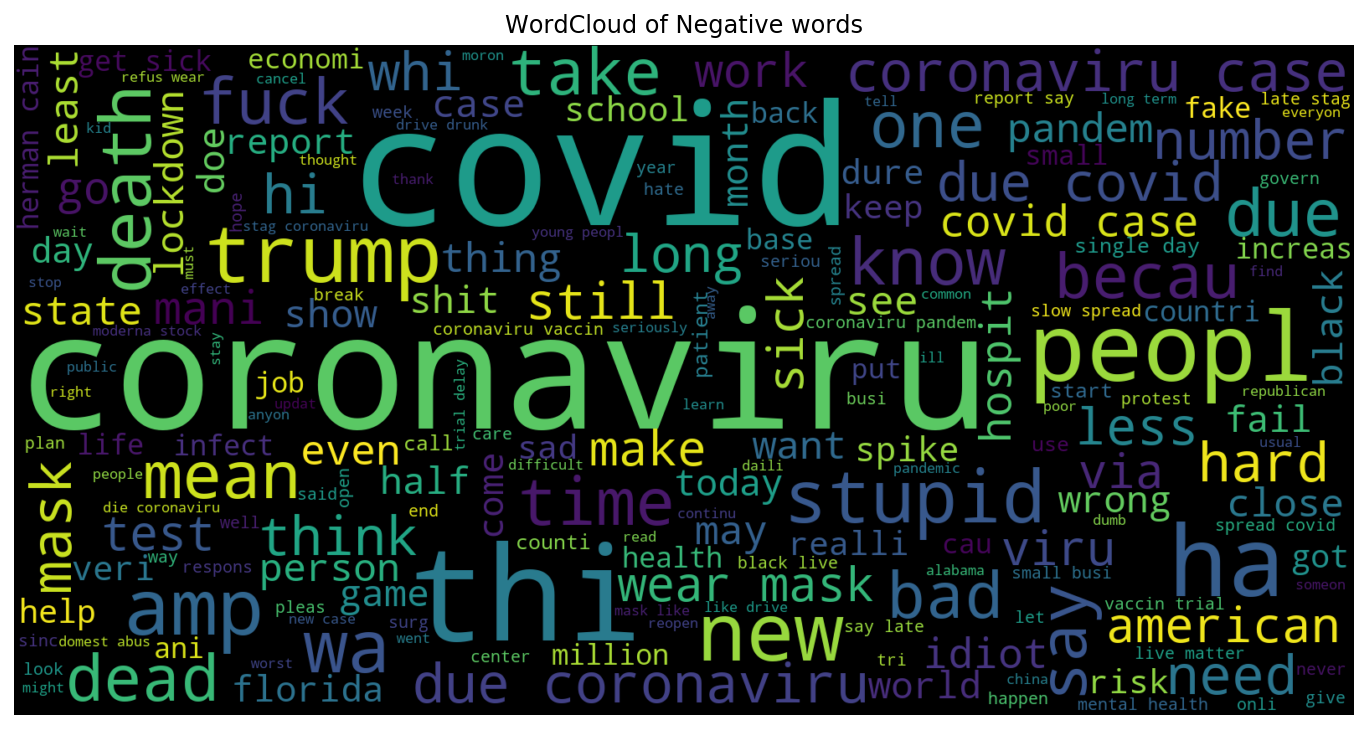

In [23]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Negative words")
plt.show()

In [24]:
pos_tweets = tweet_df[tweet_df.Polarity == 1]
pos_string = []
for t in pos_tweets.Text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

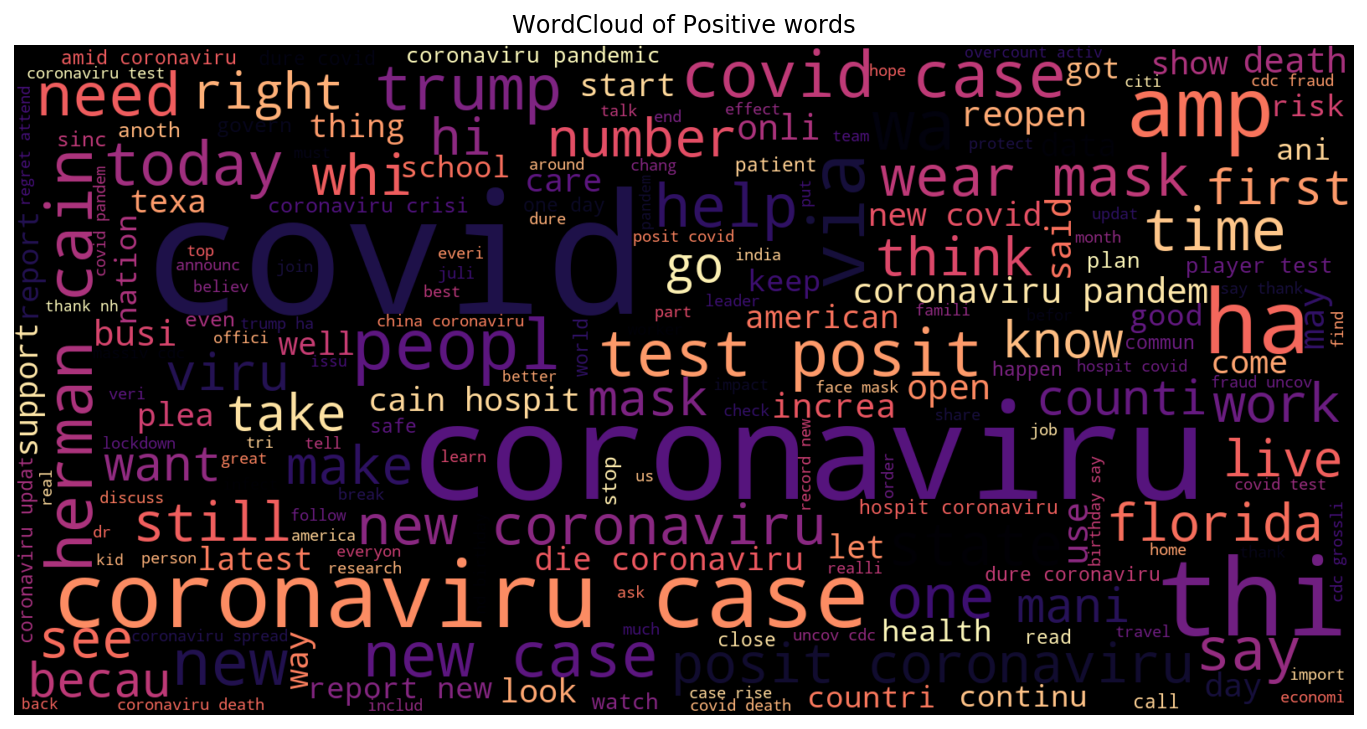

In [25]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Positive words")
plt.show()

# Splitting data into training data and test data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
data_train, data_test = train_test_split(tweet_df,test_size=0.10,random_state=42)

In [28]:
#  training data

all_training_words = [word for tokens in data_train['Tokens'] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train['Tokens']]
training_vocab = sorted(list(set(all_training_words)))
print("Total words = %s " % (len(all_training_words)))
print("Vocabulary size = %s "%(len(training_vocab)))
print("Max sentence length = %s" % max(training_sentence_lengths))

Total words = 158728 
Vocabulary size = 15941 
Max sentence length = 20


In [29]:
# test data

all_test_words = [word for tokens in data_test['Tokens'] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test['Tokens']]
test_vocab = sorted(list(set(all_test_words)))
print("Total words = %s " % (len(all_test_words)))
print("Vocabulary size = %s "%(len(test_vocab)))
print("Max sentence length = %s" % max(test_sentence_lengths))

Total words = 17421 
Vocabulary size = 4591 
Max sentence length = 17


## Load Google News Word2Vec model

In [30]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [31]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['Tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

## Get Embeddings

In [32]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [33]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

## Tokenizing and Pad Sequences

In [34]:
tokenizer = Tokenizer(num_words=len(training_embeddings), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 15941 unique tokens.


In [35]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [36]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(15942, 300)


In [37]:

test_sequences = tokenizer.texts_to_sequences(data_test["Text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## CNN model

In [38]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [39]:
label_names = ['Pos', 'Neg']

In [40]:
y_train = data_train[label_names].values

In [41]:
x_train = train_cnn_data
y_tr = y_train

In [42]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,len(list(label_names)))

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      4782600     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 200)      120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 200)      180200      embedding_1[0][0]                
____________________

In [43]:
# train cnn

num_epochs = 3  
batch_size = 20


In [44]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15189 samples, validate on 1688 samples
Epoch 1/3
15189/15189 [==============================] - 148s 10ms/step - loss: 0.3758 - acc: 0.8586 - val_loss: 0.2671 - val_acc: 0.8945
Epoch 2/3
15189/15189 [==============================] - 168s 11ms/step - loss: 0.2088 - acc: 0.9202 - val_loss: 0.1823 - val_acc: 0.9248
Epoch 3/3
15189/15189 [==============================] - 128s 8ms/step - loss: 0.1080 - acc: 0.9610 - val_loss: 0.2172 - val_acc: 0.9310


## Test CNN

In [45]:
#test model

predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)


1876/1876 [==============================] - 8s 4ms/step


In [46]:
print(predictions)

[[9.98601019e-01 1.13323331e-03]
 [9.90544498e-01 1.01748705e-02]
 [9.99491334e-01 3.72141600e-04]
 ...
 [9.30874825e-01 6.35090470e-02]
 [9.99999583e-01 2.08616257e-07]
 [9.67712998e-01 2.55680978e-02]]


In [47]:
labels = [1, 0]

In [48]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

#print(prediction_labels)

In [49]:
sum(data_test.Polarity==prediction_labels)/len(prediction_labels)

0.94136460554371

In [50]:
data_test.Polarity.value_counts()

1    1592
0     284
Name: Polarity, dtype: int64

In [51]:
# True Data

data_test['Polarity'].shape

(1876,)

In [52]:
from sklearn.metrics import confusion_matrix
from visualize import plot_confusion_matrix

In [53]:
result = confusion_matrix(data_test['Polarity'], prediction_labels)
print("Confusion MAtrix - ",result)

Confusion MAtrix -  [[ 197   87]
 [  23 1569]]


Confusion matrix, without normalization
[[ 197   87]
 [  23 1569]]


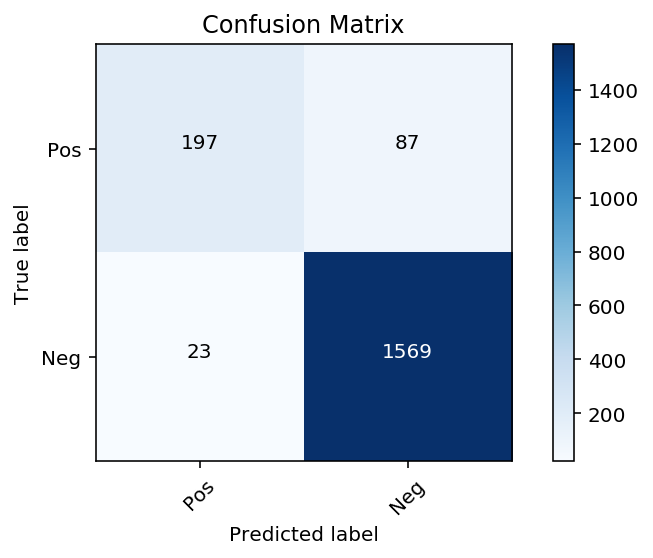

In [54]:
plot_confusion_matrix(result,classes =["Pos","Neg"],title = "Confusion Matrix")

In [55]:
# Some parameters using confusion matrix
TP = result[0][0]
FN = result[0][1]
FP = result[1][0]
TN = result[1][1]

Accuracy = (TP + TN) / (TP + TN + FP + FN)
Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
Fmeasure = (2 * Recall * Precision) / (Recall + Precision)

print("Accuracy  : ", Accuracy)
print("Recall    : ", Recall)
print("Precision : ", Precision)
print("F-measure : ", Fmeasure)

Accuracy  :  0.94136460554371
Recall    :  0.6936619718309859
Precision :  0.8954545454545455
F-measure :  0.7817460317460317


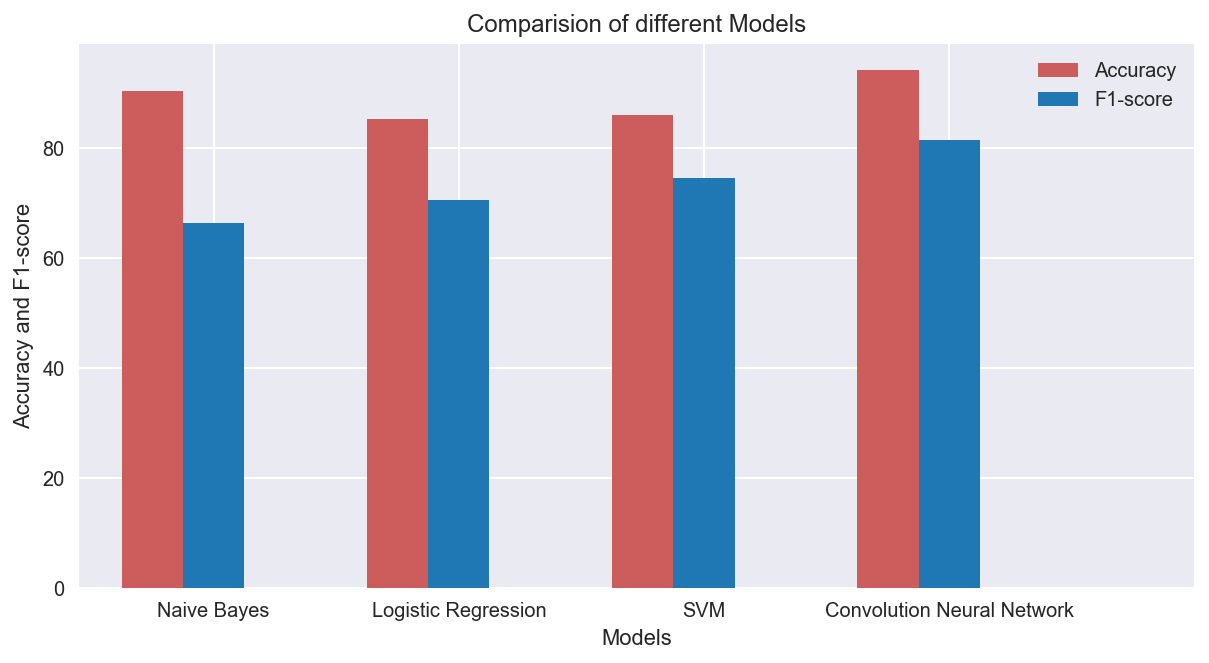

In [56]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[10,5])
# Data to be plotted
Accuracy = [90.43,85.32,86.11,94.24]
F1score = [66.33,70.61,74.5,81.55]
# Using numpy to group 3 different data with bars
X = np.arange(len(Accuracy))
# Passing the parameters to the bar function, this is the main function which creates the bar plot
# Using X now to align the bars side by side
plt.bar(X, Accuracy, color = 'indianred', width = 0.25,tick_label=True)
plt.bar(X + 0.25, F1score, color = 'tab:blue', width = 0.25,tick_label=True)
# Creating the legend of the bars in the plot
plt.legend(['Accuracy', 'F1-score'])
# Overiding the x axis with the model names
plt.xticks([i + 0.25 for i in range(5)], ["Naive Bayes","Logistic Regression","SVM","Convolution Neural Network"])
# Giving the tilte for the plot
plt.title("Comparision of different Models")
# Namimg the x and y axis
plt.xlabel('Models')
plt.ylabel('Accuracy and F1-score')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()